In [25]:
from xpbd_softbody import XPBDSoftbody
import pyvista as pv
import config as cfg
import matplotlib.pyplot as plt
import torch
from xpbd_softbody_layer import XPBDStep
import numpy as np
from sklearn.neighbors import KDTree
from xpbd_softbody_layer import get_energy_boundary
from scipy.interpolate import interp1d
from cubic_bezier import *
from tqdm import trange
from torchviz import make_dot

In [26]:
N_skin = 400
N_bandage = 400

In [27]:
# create cubic bezier spline control
u = torch.linspace(0, 1, 3).to(cfg.device)
us = torch.linspace(0, 1, 50).to(cfg.device)
start_point = np.array([[0.0099, 0.0014, 0.0013]])
start_point = torch.from_numpy(start_point).to(cfg.device)
## Parallel peeling control
# spline_control = np.array([ [0,  0.0367,  0.57],
#                             [1,  0.0367,  0.67],
#                             [2,  0.0367,  0.77]])
# Straight up peeling control
spline_control = np.array([[0.0099, 0.0014, 0.0023],
                           [0.0099, 0.0014, 0.0033],
                           [0.0099, 0.0014, 0.0043],])
spline_control = torch.from_numpy(spline_control).to(cfg.device)

In [28]:
contact_sur = torch.tensor([400, 401, 402, 403, 404, 406, 407, 408, 409, 416, 417, 418, 419, 420,
         421, 422, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 444,
         445, 447, 448, 450, 451, 452, 467, 468, 469, 470, 471, 472, 473, 474,
         475, 476, 478, 479, 492, 493, 494, 495, 496, 497, 506, 507, 508, 509,
         510, 511, 512, 513, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528,
         529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542,
         543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556,
         557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570,
         571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584,
         585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598,
         599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612,
         613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626,
         627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640,
         641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654,
         655, 656, 657, 658, 659, 660, 661]) - 400

In [29]:
# load data
softbody = XPBDSoftbody()
skin_mesh = softbody.add_thinshell(pv.Cube(center=(0, 0, 0), x_length=0.02, y_length=0.02, z_length=0.002), n_surf=N_skin)
bandage_mesh = softbody.add_thinshell(pv.Cube(center=(0, 0, 0.002), x_length=0.02, y_length=0.02, z_length=0.002), n_surf=N_bandage)
softbody.init_states()
softbody.init_dist_constraints()
softbody.init_shape_constraints_thinshell([1])
softbody.add_multi_boundary_constrain(1, 0, 0.0025, contact_sur)
softbody.fix_less_than(0, 0, 2)
softbody.fix_point(1, 50)
# softbody.fix_less_than(1, 0.002, 2)

detect 2 object


In [30]:
norm_vec = np.array([-1, -1, 0])
center = (0, 0, 0)
sig_plane = pv.Plane(center=center, direction=norm_vec, i_size=0.01, j_size=0.01)

/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


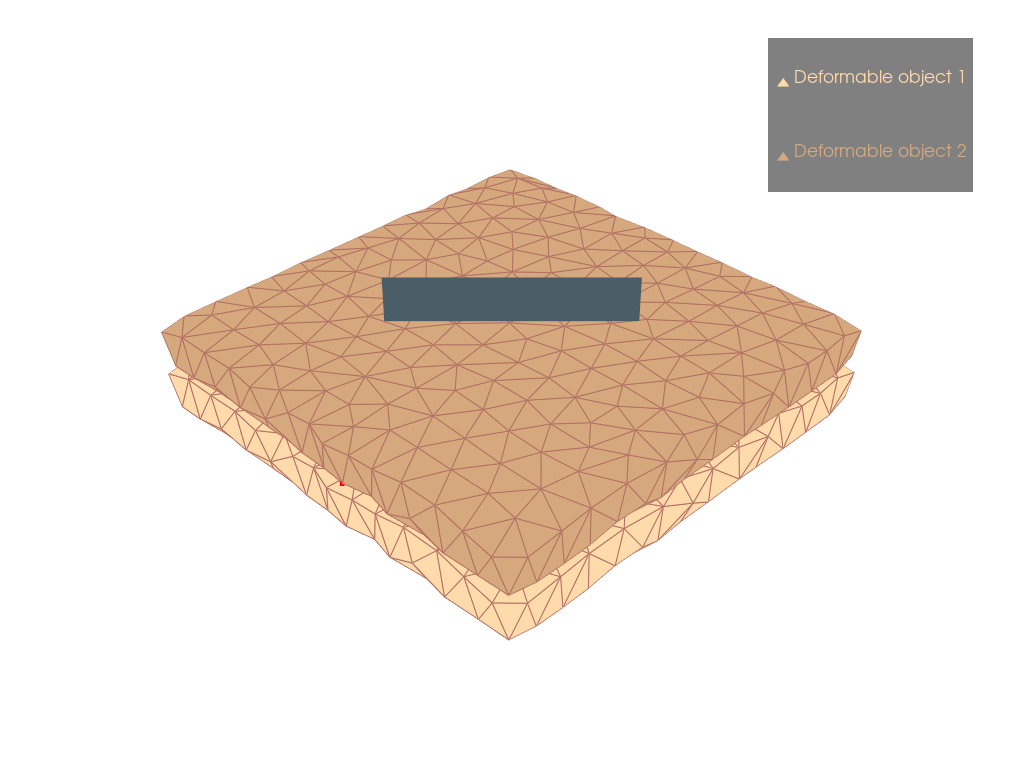

In [31]:
pl = pv.Plotter()
pl.add_mesh(skin_mesh, color='#ffdbac', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 1')
pl.add_mesh(bandage_mesh, color='#D5A97D', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 2')
pl.add_mesh(sig_plane)
pl.add_points(softbody.V[softbody.offset_list[1] + 50].cpu().numpy(), color='r')
# pl.add_mesh(bandage_mesh, scalars=color, show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Bandage')
pl.add_legend()
pl.camera_position = 'iso'
pl.show()

In [32]:
V_origin = softbody.V.clone()
V_velocity_origin = softbody.V_velocity.clone()

In [33]:
softbody.C_boundary_list[0].shape

torch.Size([2115, 2])

In [34]:
# color = np.zeros(400)
# color[306] = 1

In [35]:
cloth_dist_stiffness = 1
V_boundary_stiffness_ref = 0.1
V_dist_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device) * cloth_dist_stiffness
V_boundary_stiffness = torch.ones((softbody.C_boundary_list[0].shape[0], 1)).to(cfg.device) * V_boundary_stiffness_ref
V_shape_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)*3

In [36]:
filename = 'tissue2tissue_stiffness_' + str(V_boundary_stiffness_ref) + '.gif'
stiffness_text = 'Boundary stiffness = ' + str(V_boundary_stiffness_ref)

In [37]:
select_points = []
for i in range(softbody.V_list[1].shape[0]):
    if (norm_vec @ softbody.V_list[1][i].detach().cpu().numpy()) < 0:
        select_points.append(i + softbody.offset_list[1])

In [38]:
reveal_points = []
for i in softbody.C_boundary_V_0[0]:
    if i in select_points:
        reveal_points.append(i)

/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


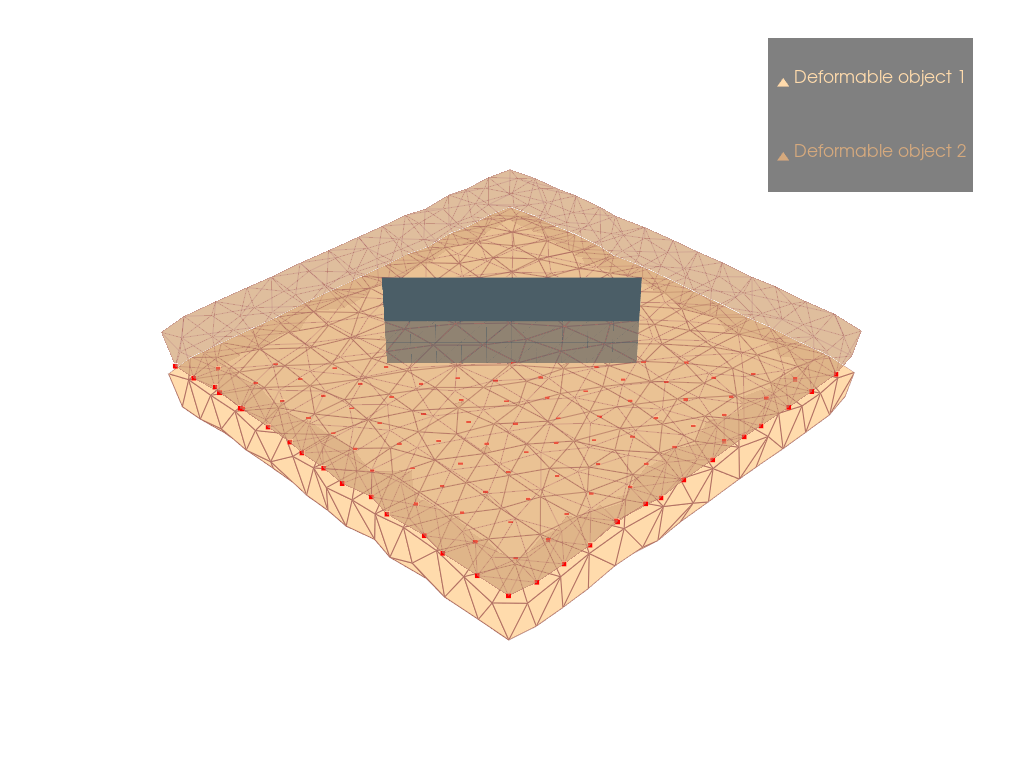

In [39]:
pl = pv.Plotter()
pl.add_mesh(skin_mesh, color='#ffdbac', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 1')
pl.add_mesh(bandage_mesh, color='#D5A97D', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 2', opacity=0.5)
pl.add_mesh(sig_plane)
pl.add_points(softbody.V[reveal_points].cpu().numpy(), color='r')
# pl.add_mesh(bandage_mesh, scalars=color, show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Bandage')
pl.add_legend()
pl.camera_position = 'iso'
pl.show()

In [40]:
boundary_mask = torch.ones((softbody.C_boundary_list[0].shape[0], 1)).to(cfg.device) * 0.1
for i in reveal_points:
    idx = torch.where(softbody.C_boundary_V_0[0] == i)[0]
    # print(idx)
    boundary_idx = softbody.C_boundary_lut_0[0][idx]
    boundary_mask[boundary_idx] = 1e-8

In [41]:
softbody.V[softbody.offset_list[1] + 50]

tensor([0.0099, 0.0014, 0.0013])

In [42]:
# Set grad parameter
spline_control.requires_grad_(True)

tensor([[0.0099, 0.0014, 0.0023],
        [0.0099, 0.0014, 0.0033],
        [0.0099, 0.0014, 0.0043]], dtype=torch.float64, requires_grad=True)

In [43]:
optimizer = torch.optim.Adam([spline_control], lr=0.001)

In [44]:
# define loss function
# target = torch.ones_like(V_boundary_stiffness) * 1e-5

def loss_fn(predict, target):
    return torch.norm(target - predict)

In [45]:
## evaluation function
def eval(predict, target):
    predict_revealed = predict < 1e-2
    predict_unrevealed = predict > 1e-2
    # print(torch.sum(predict_revealed))
    target_revealed = target < 1e-2
    target_unrevealed = target > 1e-2

    # calculate arrcuary reveal
    reveal_acc = torch.sum(torch.logical_and(predict_revealed, target_revealed)) / torch.sum(target_revealed)
    unreveal_acc = torch.sum(torch.logical_and(predict_unrevealed, target_unrevealed)) / torch.sum(target_unrevealed)

    return reveal_acc, unreveal_acc

In [46]:
softbody.V[softbody.offset_list[1] + 306]

tensor([-0.0008, -0.0059,  0.0030])

In [47]:
# torch.autograd.set_detect_anomaly(False)
softbody.C_boundary_list[0].shape

torch.Size([2115, 2])

itr 0


100%|██████████| 7/7 [00:01<00:00,  3.55it/s]


loss: tensor(2.7810, dtype=torch.float64, grad_fn=<LinalgVectorNormBackward0>)
Accuracy: (tensor(0.2358), tensor(1.))
tensor([[ -5.5323,  -6.0044,  93.8967],
        [ -4.2728,  -6.2101,  19.6979],
        [-39.9809,  -1.2601, -44.4308]], dtype=torch.float64)


/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


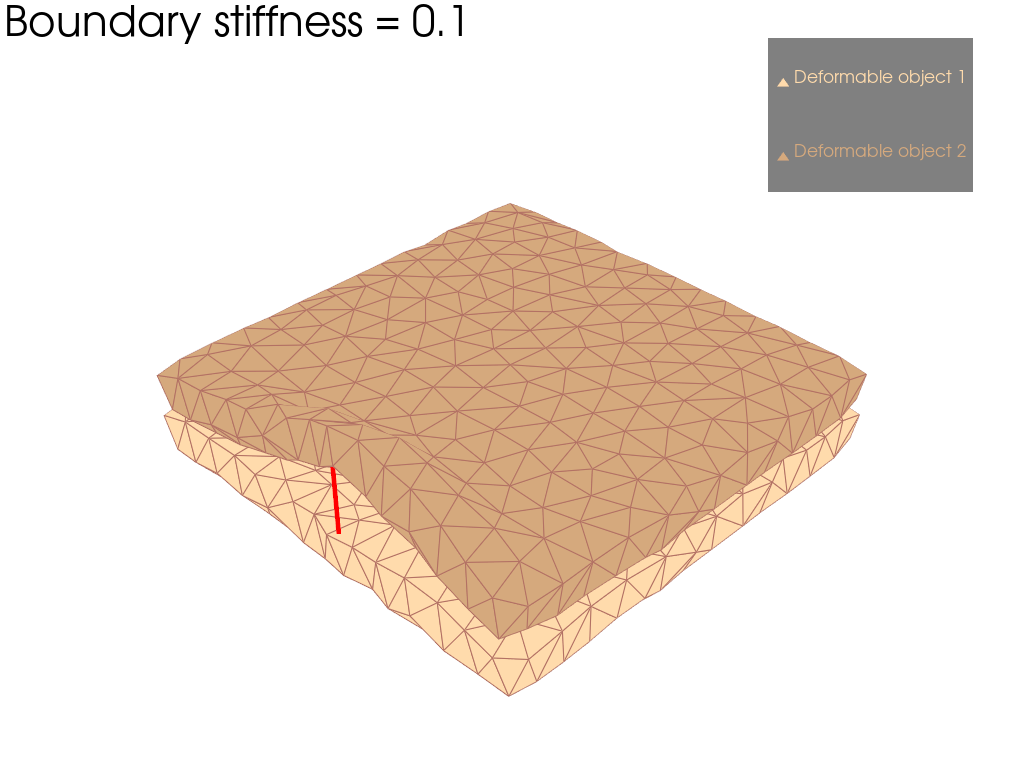

itr 1


100%|██████████| 10/10 [00:02<00:00,  3.68it/s]


loss: tensor(2.4865, dtype=torch.float64, grad_fn=<LinalgVectorNormBackward0>)
Accuracy: (tensor(0.4002), tensor(0.9817))
tensor([[ -4.7318,  28.1641, -22.4620],
        [-60.8356,   3.4063,   1.2436],
        [  2.5348, 233.3779,  -2.8800]], dtype=torch.float64)
itr 2


100%|██████████| 13/13 [00:03<00:00,  4.26it/s]


loss: tensor(2.2497, dtype=torch.float64, grad_fn=<LinalgVectorNormBackward0>)
Accuracy: (tensor(0.5385), tensor(0.9576))
tensor([[118.2352,  56.0761, -97.6148],
        [117.6675, 151.6967, -22.2347],
        [217.6585, 601.6935, 104.4286]], dtype=torch.float64)
itr 3


100%|██████████| 11/11 [00:03<00:00,  3.57it/s]


loss: tensor(2.0768, dtype=torch.float64, grad_fn=<LinalgVectorNormBackward0>)
Accuracy: (tensor(0.4698), tensor(0.9846))
tensor([[ 114.4051,  -29.6500, -137.1357],
        [ -34.3945,   50.0499,  -26.6184],
        [-279.4238,  201.0633,    6.0338]], dtype=torch.float64)
itr 4


100%|██████████| 9/9 [00:02<00:00,  3.59it/s]


loss: tensor(2.0198, dtype=torch.float64, grad_fn=<LinalgVectorNormBackward0>)
Accuracy: (tensor(0.4373), tensor(0.9971))
tensor([[ 179.9775, -157.0670,  -73.9783],
        [  30.1522,   55.0845,    6.3726],
        [-159.0778,  169.5501,   25.2284]], dtype=torch.float64)
itr 5


100%|██████████| 9/9 [00:02<00:00,  4.05it/s]


loss: tensor(1.9427, dtype=torch.float64, grad_fn=<LinalgVectorNormBackward0>)
Accuracy: (tensor(0.5590), tensor(0.9711))
tensor([[-52.8540, -13.8433,  65.1257],
        [-24.9452,  -7.0445,  25.4544],
        [ 66.8880,  -0.4406, -13.3750]], dtype=torch.float64)


/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


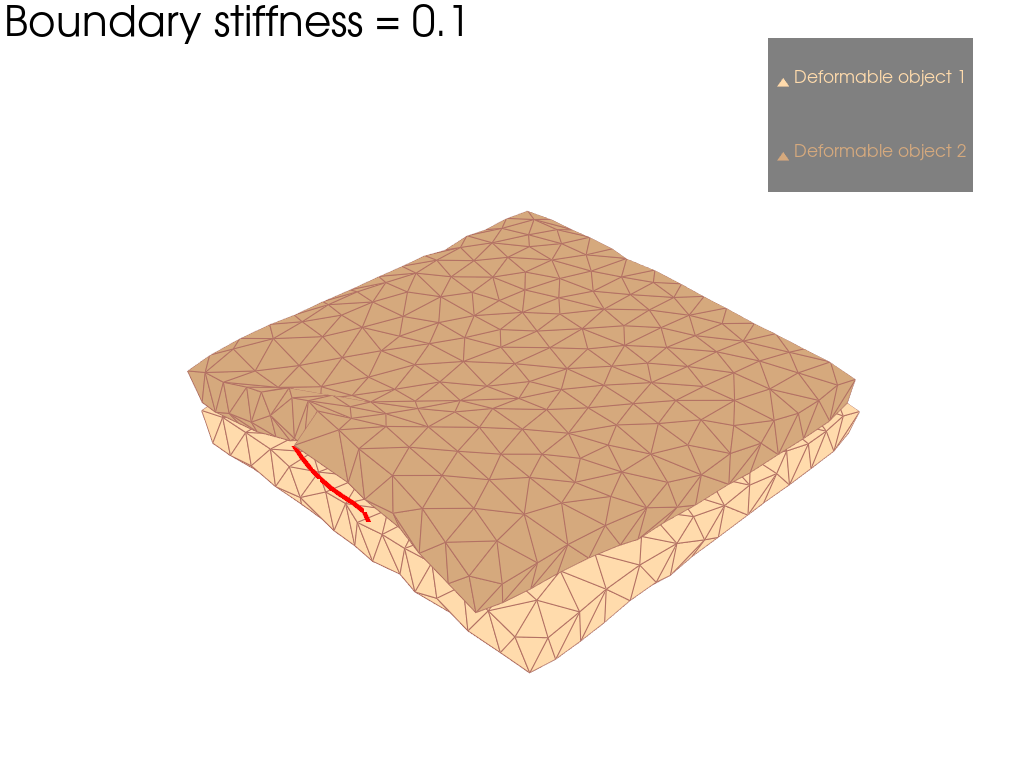

itr 6


100%|██████████| 10/10 [00:02<00:00,  3.54it/s]


loss: tensor(1.9455, dtype=torch.float64, grad_fn=<LinalgVectorNormBackward0>)
Accuracy: (tensor(0.6332), tensor(0.9287))
tensor([[-60.4688, -24.2955,  18.4914],
        [-33.0604, -46.8985,  -8.4915],
        [115.4722, -45.9094, -74.5243]], dtype=torch.float64)
itr 7


100%|██████████| 12/12 [00:03<00:00,  3.96it/s]


loss: tensor(1.9127, dtype=torch.float64, grad_fn=<LinalgVectorNormBackward0>)
Accuracy: (tensor(0.7827), tensor(0.8382))
tensor([[ 36.9399, -18.6263, -15.7822],
        [ 16.2970,  -2.5096,  -3.6257],
        [124.1832, -57.9483, -78.8222]], dtype=torch.float64)
itr 8


100%|██████████| 13/13 [00:03<00:00,  3.68it/s]


loss: tensor(1.9173, dtype=torch.float64, grad_fn=<LinalgVectorNormBackward0>)
Accuracy: (tensor(0.7809), tensor(0.8295))
tensor([[ 40.4113,  -9.9420,   0.7590],
        [ 32.0112,  22.2238,  22.9858],
        [ 92.3914, -25.3530, -31.6161]], dtype=torch.float64)
itr 9


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


loss: tensor(1.8910, dtype=torch.float64, grad_fn=<LinalgVectorNormBackward0>)
Accuracy: (tensor(0.8468), tensor(0.8372))
tensor([[-22.8799,  68.7643, 104.0742],
        [-17.1912,  47.1362,  90.5273],
        [227.5338, -10.0977,  -9.1715]], dtype=torch.float64)
itr 10


100%|██████████| 16/16 [00:04<00:00,  3.84it/s]


loss: tensor(1.8386, dtype=torch.float64, grad_fn=<LinalgVectorNormBackward0>)
Accuracy: (tensor(0.8552), tensor(0.8516))
tensor([[ 233.3914, -154.0664, -123.4025],
        [ 116.5503,  -25.2411,  -52.2581],
        [ 303.0596,  -72.3809,  -55.1259]], dtype=torch.float64)


/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


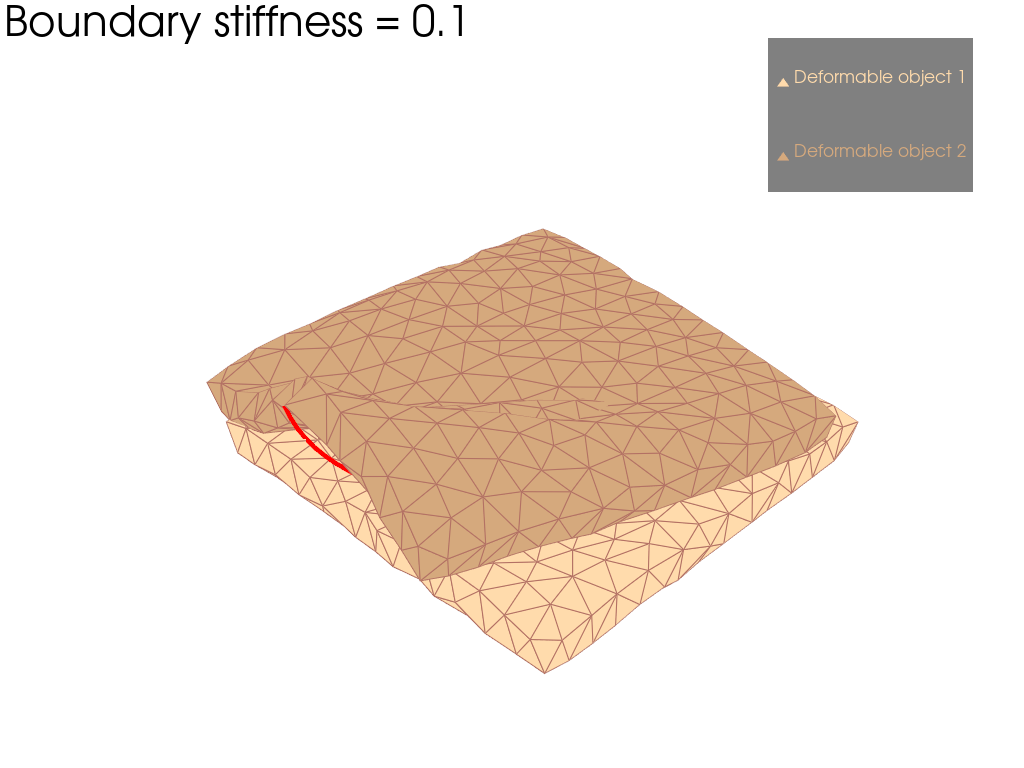

itr 11


100%|██████████| 17/17 [00:04<00:00,  3.91it/s]


loss: tensor(1.7350, dtype=torch.float64, grad_fn=<LinalgVectorNormBackward0>)
Accuracy: (tensor(0.8357), tensor(0.9171))
tensor([[ 222.5342,  -48.8177,   58.7345],
        [ 141.3534,   13.3847,   38.2889],
        [ 189.1499, -105.3394,  -46.6946]], dtype=torch.float64)
itr 12


100%|██████████| 19/19 [00:05<00:00,  3.77it/s]


loss: tensor(1.5958, dtype=torch.float64, grad_fn=<LinalgVectorNormBackward0>)
Accuracy: (tensor(0.7976), tensor(0.9605))
tensor([[ -21.0522,  -58.9019,   15.1238],
        [   4.6970,  -36.3561,    1.5593],
        [ 262.4833, -125.8081,  -52.4270]], dtype=torch.float64)
itr 13


100%|██████████| 21/21 [00:06<00:00,  3.48it/s]


loss: tensor(1.5031, dtype=torch.float64, grad_fn=<LinalgVectorNormBackward0>)
Accuracy: (tensor(0.7521), tensor(0.9875))
tensor([[60.9877, 67.5061, 59.5761],
        [48.1605, 61.3512, 60.9795],
        [45.1850, -0.7289, 37.2992]], dtype=torch.float64)
itr 14


100%|██████████| 23/23 [00:06<00:00,  3.79it/s]


loss: tensor(1.4404, dtype=torch.float64, grad_fn=<LinalgVectorNormBackward0>)
Accuracy: (tensor(0.7428), tensor(0.9981))
tensor([[-4.8277e+01,  5.0641e+01, -1.4683e+01],
        [-9.6453e+00,  2.3604e+01, -8.4284e+00],
        [ 5.3433e+00, -4.6573e+00,  6.3596e-03]], dtype=torch.float64)
itr 15


100%|██████████| 24/24 [00:06<00:00,  3.80it/s]


loss: tensor(1.4855, dtype=torch.float64, grad_fn=<LinalgVectorNormBackward0>)
Accuracy: (tensor(0.6899), tensor(0.9971))
tensor([[-78.9356,  63.8871, -15.1677],
        [-44.3888,  18.0221, -20.7004],
        [-58.6331,  52.2590,  -3.7530]], dtype=torch.float64)


/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


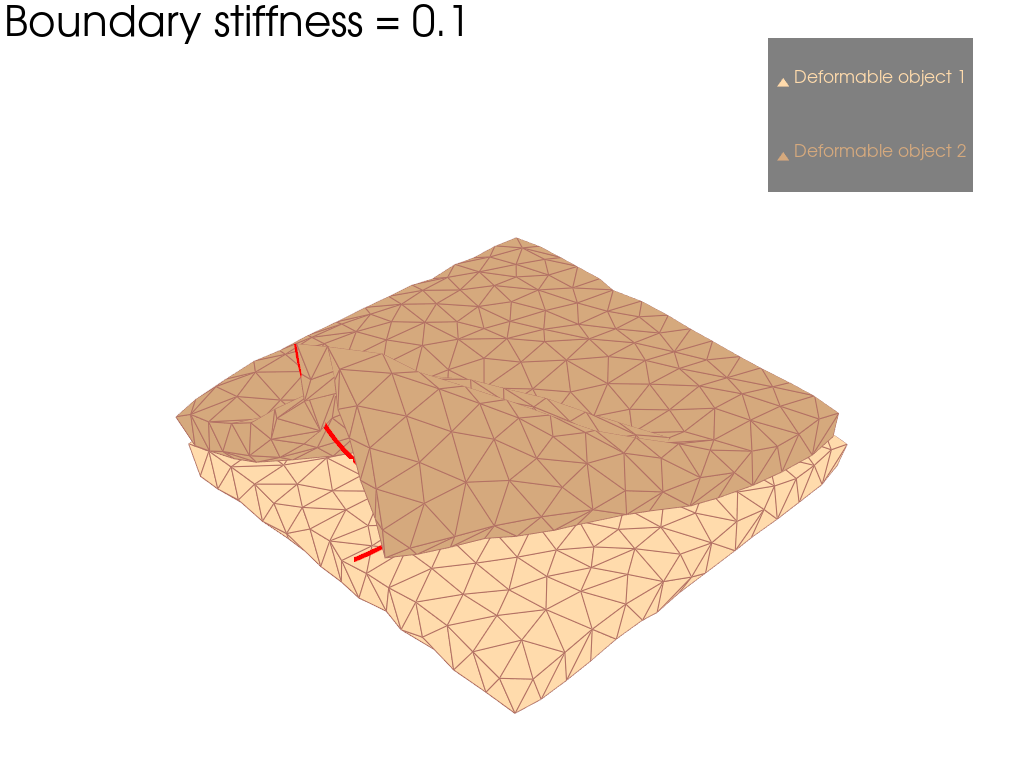

itr 16


100%|██████████| 26/26 [00:06<00:00,  3.95it/s]


loss: tensor(1.3608, dtype=torch.float64, grad_fn=<LinalgVectorNormBackward0>)
Accuracy: (tensor(0.7428), tensor(0.9942))
tensor([[-82.2502,  45.1273, -24.2078],
        [-32.3310,  -7.7644, -24.7018],
        [-26.8367, -56.5391, -29.8184]], dtype=torch.float64)
itr 17


100%|██████████| 26/26 [00:06<00:00,  3.72it/s]


loss: tensor(1.4143, dtype=torch.float64, grad_fn=<LinalgVectorNormBackward0>)
Accuracy: (tensor(0.7131), tensor(0.9904))
tensor([[  58.2429,  -15.4019,  -94.8166],
        [ 101.7801,  -75.8452, -114.0771],
        [  44.9336,  -85.9577,  -82.2978]], dtype=torch.float64)
itr 18


100%|██████████| 27/27 [00:07<00:00,  3.61it/s]


loss: tensor(1.3111, dtype=torch.float64, grad_fn=<LinalgVectorNormBackward0>)
Accuracy: (tensor(0.7354), tensor(0.9933))
tensor([[-159.6005,  193.4432,  -79.5495],
        [ -29.5385,  -81.0598, -210.1269],
        [ -49.8165, -109.4980, -152.9633]], dtype=torch.float64)
itr 19


100%|██████████| 28/28 [00:08<00:00,  3.50it/s]


loss: tensor(1.1315, dtype=torch.float64, grad_fn=<LinalgVectorNormBackward0>)
Accuracy: (tensor(0.8143), tensor(0.9913))
tensor([[-170.3385,   80.8305,  -33.8745],
        [-114.2577,  -17.2939,  -38.8581],
        [ -24.7158,  -71.4872,  -35.7670]], dtype=torch.float64)
itr 20


100%|██████████| 28/28 [00:07<00:00,  3.64it/s]


loss: tensor(1.0841, dtype=torch.float64, grad_fn=<LinalgVectorNormBackward0>)
Accuracy: (tensor(0.8282), tensor(0.9904))
tensor([[-100.4507,  130.1961,   -5.4248],
        [ -18.6496,    6.9994,  -10.7701],
        [ -33.6684,    0.6660,  -31.5119]], dtype=torch.float64)


/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


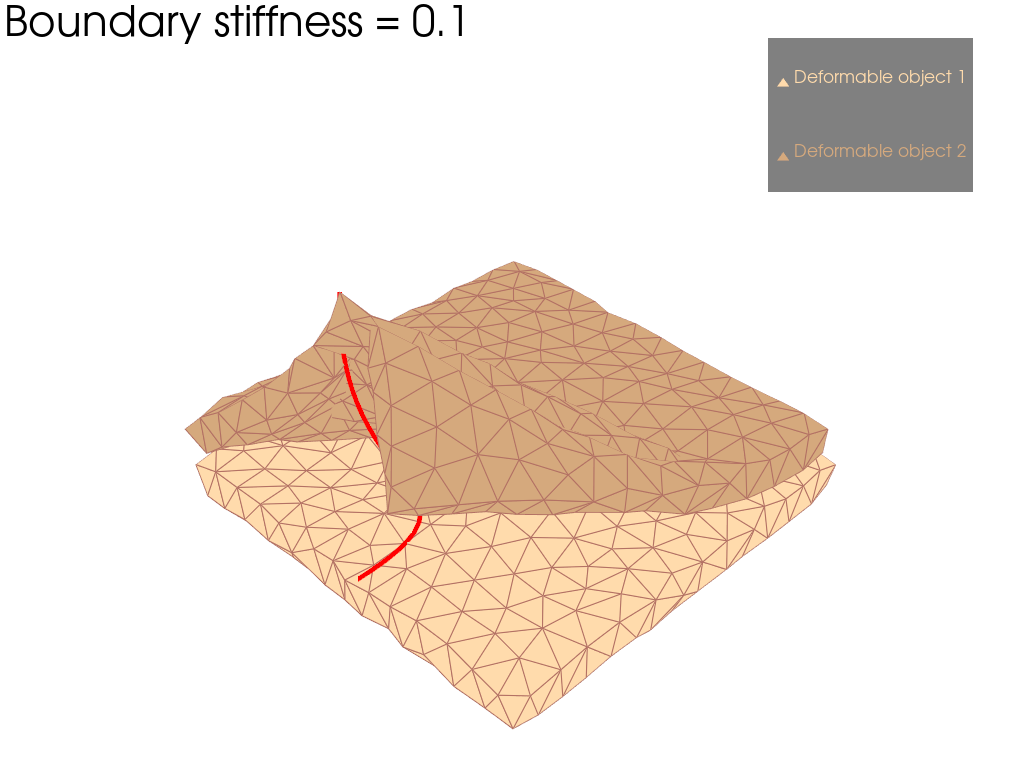

itr 21


 71%|███████▏  | 20/28 [00:05<00:02,  3.73it/s]


KeyboardInterrupt: 

In [48]:
spline_list = []
# pl.open_gif(filename)
for t in range(60):
    print('itr', t)
    # get cubic bezier spline control after step
    x_con = torch.cat((start_point[:, 0], spline_control[:, 0]))
    y_con = torch.cat((start_point[:, 1], spline_control[:, 1]))
    z_con = torch.cat((start_point[:, 2], spline_control[:, 2]))
    spline = cubic_bezier_arc_3D(x_con, y_con, z_con, 0.0005)
    spline_x = spline[0]
    spline_y = spline[1]
    spline_z = spline[2]
    spline_trajectory = torch.transpose(torch.vstack((spline_x, spline_y, spline_z)), 0, 1)
    # print(spline_trajectory)
    # restore original vertex and velocity
    softbody.V = V_origin.clone()
    softbody.V_velocity = V_velocity_origin.clone()

    # restore stiffness
    cloth_dist_stiffness = 1
    V_boundary_stiffness_ref = 0.1
    V_dist_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)
    V_boundary_stiffness = torch.ones((softbody.C_boundary_list[0].shape[0], 1)).to(cfg.device) * V_boundary_stiffness_ref
    V_shape_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)*0.0005
    
    for i in trange(spline_trajectory.shape[0]):
    # for i in range(1):
        softbody.V[softbody.offset_list[1] + 50] = spline_trajectory[i]
        
        step_ref = XPBDStep(softbody,
                    V_dist_stiffness=V_dist_stiffness, 
                    V_shape_stiffness=V_shape_stiffness,
                    V_boundary_stiffness=V_boundary_stiffness, 
                    dt=cfg.dt,
                    substep=cfg.substep,
                    iteration=cfg.iteration,
                    quasi_static=cfg.quasi_static,
                    plane_height=cfg.ground_plane_height, 
                    use_shape_matching=False,
                    use_spring_boundary=True,
                    use_dist=True)
        V_ref, V_velocity_ref = step_ref.forward(softbody.V, softbody.V_velocity)
        softbody.V = V_ref.clone()
        softbody.V_velocity = V_velocity_ref.clone()
        # print((softbody.V == torch.inf).any())
        ref_V_boundary_stiffness = V_boundary_stiffness.clone()
        energy = get_energy_boundary(softbody, softbody.V, ref_V_boundary_stiffness)
        V_boundary_stiffness = V_boundary_stiffness * torch.sigmoid(1e9 * (1e-8 - energy)) + 1e-8 * torch.sigmoid(1e9 * (energy - 1e-8))
        skin_mesh.points = softbody.V[:N_skin].detach().cpu().numpy()
        bandage_mesh.points = softbody.V[N_skin:N_bandage+N_skin].detach().cpu().numpy()
    # loss = torch.norm(V_boundary_stiffness)
    loss = loss_fn(V_boundary_stiffness, boundary_mask)
    # loss = torch.norm(V_ref)
    # loss = loss_fn(softbody.V[softbody.offset_list[1] + 305], target)
    loss.backward()
    print('loss:', loss)
    print('Accuracy:', eval(V_boundary_stiffness, boundary_mask))
    print(spline_control.grad)
    spline_list.append(spline_trajectory)
    if t % 5 == 0:
        pl = pv.Plotter()
        pl.add_mesh(skin_mesh, color='#ffdbac', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 1')
        pl.add_mesh(bandage_mesh, color='#D5A97D', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 2')
        pl.add_lines(spline_trajectory.detach().cpu().numpy(), connected=True, color='r')
        pl.add_text(stiffness_text)
        # pl.add_mesh(bandage_mesh, scalars=color, show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Bandage')
        pl.add_legend()
        pl.camera_position = 'iso'
        pl.show()
        
    optimizer.step()
    optimizer.zero_grad()

# pl.close()

/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


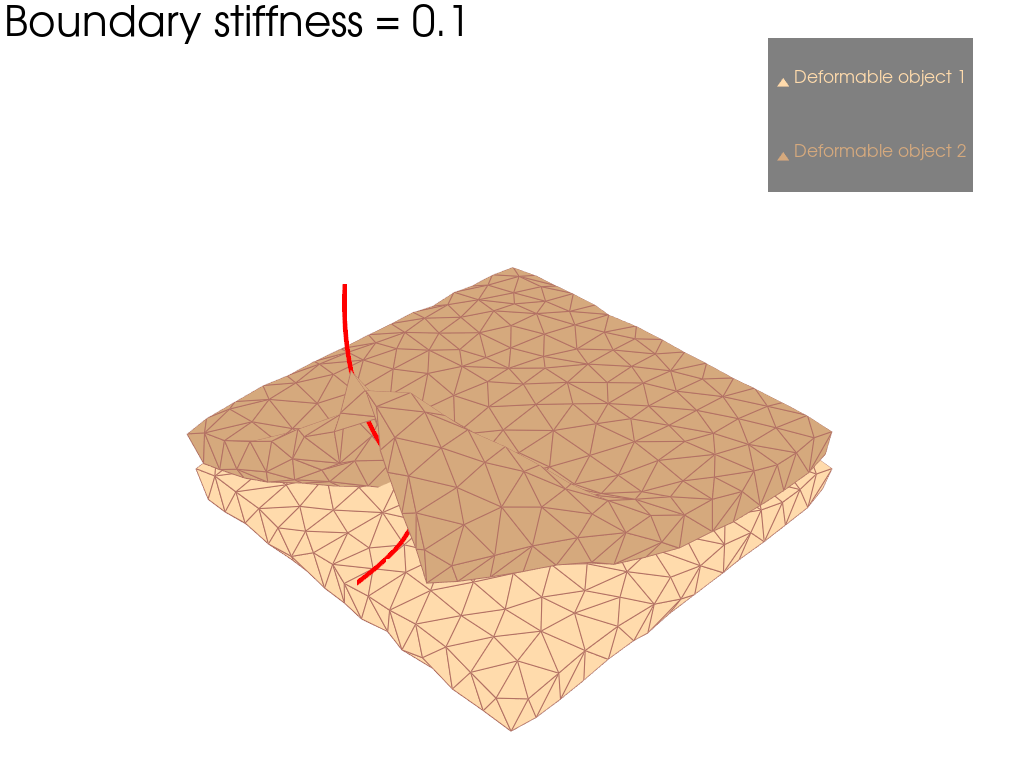

In [49]:
pl = pv.Plotter()
pl.add_mesh(skin_mesh, color='#ffdbac', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 1')
pl.add_mesh(bandage_mesh, color='#D5A97D', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 2')
pl.add_lines(spline_trajectory.detach().cpu().numpy(), connected=True, color='r')
pl.add_text(stiffness_text)
# pl.add_mesh(bandage_mesh, scalars=color, show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Bandage')
pl.add_legend()
pl.camera_position = 'iso'
pl.show()

In [61]:
pl = pv.Plotter()
pl.add_mesh(skin_mesh, color='#ffdbac', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 1')
pl.add_mesh(bandage_mesh, color='#D5A97D', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 2')
pl.add_text(stiffness_text)
# pl.add_mesh(bandage_mesh, scalars=color, show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Bandage')
pl.add_legend()
pl.camera_position = 'iso'

In [62]:
pl.open_gif('tissue2tissue_opt.gif')
for spline_trajectory in spline_list:
    softbody.V = V_origin.clone()
    softbody.V_velocity = V_velocity_origin.clone()

    # restore stiffness
    cloth_dist_stiffness = 1
    V_boundary_stiffness_ref = 0.1
    V_dist_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)
    V_boundary_stiffness = torch.ones((softbody.C_boundary_list[0].shape[0], 1)).to(cfg.device) * V_boundary_stiffness_ref
    V_shape_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)*0.0005
    
    spline_actor = pl.add_lines(spline_trajectory.detach().cpu().numpy(), connected=True, color='r')
    for i in trange(spline_trajectory.shape[0]):
        softbody.V[softbody.offset_list[1] + 50] = spline_trajectory[i]
        
        step_ref = XPBDStep(softbody,
                    V_dist_stiffness=V_dist_stiffness, 
                    V_shape_stiffness=V_shape_stiffness,
                    V_boundary_stiffness=V_boundary_stiffness, 
                    dt=cfg.dt,
                    substep=cfg.substep,
                    iteration=cfg.iteration,
                    quasi_static=cfg.quasi_static,
                    plane_height=cfg.ground_plane_height, 
                    use_shape_matching=False,
                    use_spring_boundary=True,
                    use_dist=True)
        V_ref, V_velocity_ref = step_ref.forward(softbody.V, softbody.V_velocity)
        softbody.V = V_ref.clone()
        softbody.V_velocity = V_velocity_ref.clone()
        # print((softbody.V == torch.inf).any())
        ref_V_boundary_stiffness = V_boundary_stiffness.clone()
        energy = get_energy_boundary(softbody, softbody.V, ref_V_boundary_stiffness)
        V_boundary_stiffness = V_boundary_stiffness * torch.sigmoid(1e9 * (1e-8 - energy)) + 1e-8 * torch.sigmoid(1e9 * (energy - 1e-8))
        skin_mesh.points = softbody.V[:N_skin].detach().cpu().numpy()
        bandage_mesh.points = softbody.V[N_skin:N_bandage+N_skin].detach().cpu().numpy()
        pl.write_frame()
    pl.remove_actor(spline_actor)
    # loss = torch.norm(V_boundary_stiffness)

pl.close()

100%|██████████| 28/28 [00:11<00:00,  2.53it/s]
